# MIT (TA1): From Paper and Code to annotated Petri Nets

#### Mike Cafarella, Chunwei Liu, Markos Markakis, Peter Chen

## 0. Preprocessing

In [74]:
import ast, json, requests, os
from IPython import display
from gpt_key import *

API_ROOT = "http://localhost:8000/"

#### We can run a local script to consolidate the "content" fields to get just the text of the paper:

## 1. Extracting variables and annotating them from the text and the DKG

#### Using our API (powered by GPT-3), we can extract variables from the paper alongside a list of possible definitions, and ground each of these variables to the MIRA DKG (thanks Harvard team!). If you're interested, the JSON format of our intermediate output can be found [here](https://github.com/mikecafarella/mitaskem/blob/main/JSONformat.md).

In [75]:
with open("bucky_short.txt", "r") as f:
        text = f.read()           
        dct_extract = {"text":text, "gpt_key":GPT_KEY}           
        json_str = requests.post(API_ROOT + "annotation/find_text_vars/", params=dct_extract).text

In [76]:
ast.literal_eval(json_str)

[{'type': 'variable',
  'name': 'S_i j',
  'id': 'v0',
  'text_annotations': [' Proportion of individuals who are susceptible to the virus'],
  'dkg_annotations': [['vsmo:0002217', 'Oropsylla bruneri']]},
 {'type': 'variable',
  'name': 'E_i j',
  'id': 'v1',
  'text_annotations': [' Proportion of individuals who have been exposed to the virus'],
  'dkg_annotations': [['vsmo:0000766', 'Anopheles annularis']]},
 {'type': 'variable',
  'name': 'I_i, j^hosp',
  'id': 'v2',
  'text_annotations': [' Proportion of individuals that are exhibiting severe disease symptoms and are in need of hospitalization'],
  'dkg_annotations': []},
 {'type': 'variable',
  'name': 'I_i, j^mild',
  'id': 'v3',
  'text_annotations': [' Proportion of individuals that are exhibiting mild disease symptoms'],
  'dkg_annotations': []},
 {'type': 'variable',
  'name': 'I_i, j^asym',
  'id': 'v4',
  'text_annotations': [' Proportion of individuals who are infected but asymptomatic'],
  'dkg_annotations': []},
 {'type'

## 2. Adding annotations from dataset columns

#### Alongside the text, we might also have discovered a collection of datasets that we think might be relevant:

In [39]:
with open("../../resources/dataset/covid_confirmed_usafacts.csv") as f:
    dataset_1 = f.read()
    print(dataset_1[:150])

countyFIPS,County Name,State,StateFIPS,2020-01-22
0,"Statewide Unallocated","AL","01",0
1001,"Autauga County ","AL","01",0


In [40]:
with open("../../resources/dataset/covid_deaths_usafacts.csv") as f:
    dataset_2 = f.read()
    print(dataset_2[:150])

countyFIPS,County Name,State,StateFIPS,2020-01-22
0,"Statewide Unallocated","AL","01",0
1001,"Autauga County ","AL","01",0


#### Let's collect just the column names into a single file:

In [41]:
dir = "../../resources/dataset/"
with open(os.path.join(dir,"headers.txt"), "w+") as fw:
    for filename in os.listdir(dir):
        file = os.path.join(dir, filename)
        if os.path.isfile(file) and file.endswith(".csv"):
            fw.write("{}:\t{}".format(filename, open(file, "r").readline()))

In [42]:
with open(os.path.join(dir,"headers.txt")) as f:
    dataset_str = f.read()
    print(dataset_str[:419])

COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Archive_Repository.csv:	Update Date,Days Since Update,User,Rows,Row Change,Columns,Column Change,Metadata Published,Metadata Updates,Column Level Metadata,Column Level Metadata Updates,Archive Link
StatewideCOVID-19CasesDeathsTests.csv:	date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,posi


#### Now we can call our `annotation/link_datasets_to_vars` endpoint to map variables discovered earlier to any matching dataset columns (GIGO warning here):

In [43]:
dct_cols = {"json_str":json_str, "dataset_str": dataset_str, "gpt_key":GPT_KEY}           
json_str = requests.post(API_ROOT + "annotation/link_datasets_to_vars/", params=dct_cols).text
json_str

'[{"type":"variable","name":"S_i j","id":"v0","text_annotations":[" Proportion of individuals who are susceptible to the virus"],"dkg_annotations":[["vsmo:0002217","Oropsylla bruneri"]],"data_annotations":["",""]},{"type":"variable","name":"E_i j","id":"v1","text_annotations":[" Proportion of individuals who have been exposed to the virus"],"dkg_annotations":[["vsmo:0000766","Anopheles annularis"]],"data_annotations":[["nychealth.csv","PROBABLE_CASE_COUNT"],["nychealth.csv","PROBABLE_DEATH_COUNT"]]},{"type":"variable","name":"I_i, j^hosp","id":"v2","text_annotations":[" Proportion of individuals that are exhibiting severe disease symptoms and are in need of hospitalization"],"dkg_annotations":[],"data_annotations":[["nychealth.csv","HOSPITALIZED_COUNT"],["nychealth.csv","HOSP_COUNT_7DAY_AVG"]]},{"type":"variable","name":"I_i, j^mild","id":"v3","text_annotations":[" Proportion of individuals that are exhibiting mild disease symptoms"],"dkg_annotations":[],"data_annotations":["",""]},{"t

In [44]:
ast.literal_eval(json_str)

[{'type': 'variable',
  'name': 'S_i j',
  'id': 'v0',
  'text_annotations': [' Proportion of individuals who are susceptible to the virus'],
  'dkg_annotations': [['vsmo:0002217', 'Oropsylla bruneri']],
  'data_annotations': ['', '']},
 {'type': 'variable',
  'name': 'E_i j',
  'id': 'v1',
  'text_annotations': [' Proportion of individuals who have been exposed to the virus'],
  'dkg_annotations': [['vsmo:0000766', 'Anopheles annularis']],
  'data_annotations': [['nychealth.csv', 'PROBABLE_CASE_COUNT'],
   ['nychealth.csv', 'PROBABLE_DEATH_COUNT']]},
 {'type': 'variable',
  'name': 'I_i, j^hosp',
  'id': 'v2',
  'text_annotations': [' Proportion of individuals that are exhibiting severe disease symptoms and are in need of hospitalization'],
  'dkg_annotations': [],
  'data_annotations': [['nychealth.csv', 'HOSPITALIZED_COUNT'],
   ['nychealth.csv', 'HOSP_COUNT_7DAY_AVG']]},
 {'type': 'variable',
  'name': 'I_i, j^mild',
  'id': 'v3',
  'text_annotations': [' Proportion of individuals 

## 3. Extracting LaTeX from formula images [Missing]

####  Here is a formula image from the SIDARTHE paper:

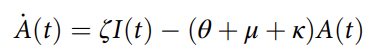

In [40]:
display.Image("../../resources/images/SIDARTHE/sidarthe_dAdt.png")

#### As we demoed last week, we can extract LaTeX from such formula images (powered by `pix2tex`), also through a public API.

In [41]:
directory = '../../resources/images/SIDARTHE'
latex_strs = []
 
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    latex_str = !python3 img_latex.py -p {f} # This is a local script that resizes the image and calls the public API.
    latex_strs.append(latex_str[0])

print(latex_strs)

['"{\\\\dot{A}}(t)=\\\\zeta I(t)-(\\\\theta+\\\\mu+\\\\kappa)A(t)"', '"{\\\\dot{D}}(t)=\\\\varepsilon I(t)-(\\\\eta+\\\\rho)D(t)"', '"\\\\dot{\\\\bar{F}}(t)\\\\,\\\\longrightarrow\\\\,\\\\tau\\\\,T(t)"', '"H(t)=i I(t)+\\\\theta b(t)+\\\\kappa d(t)+i R(t)+\\\\sigma T(t)"', '"\\\\scriptstyle I_{\\\\theta\\\\theta}=\\\\delta\\\\theta\\\\theta\\\\theta+I_{\\\\theta\\\\theta}+\\\\gamma\\\\xi\\\\theta_{1}+\\\\delta\\\\theta_{1})-\\\\epsilon+\\\\xi+\\\\delta I_{\\\\theta}"', '"R(t)=\\\\eta D(t)+\\\\theta A(t)-(\\\\nu+\\\\xi)R(t)"', '"\\\\delta(t)=-S(t)(a l(t)+\\\\theta D(t)+r A(t)+\\\\delta t(t)"', '"{\\\\hat{T}}(t)=\\\\mu A(t)+\\\\nu R(t)-(\\\\sigma+\\\\tau){\\\\hat{T}}(t)"']


## 4. Linking variables from the LaTeX formulas to variables from the text [Missing]

#### We just extracted all these equations in LaTeX, which include variables. Let's link these variables to the variables we found from the text in part 1.  Again, the output (internal)JSON format can be found [here](https://github.com/mikecafarella/mitaskem/blob/main/JSONformat.md)

In [42]:
for latex_str in latex_strs:
    dct_latex = {"json_str":json_str, "formula": latex_str, "gpt_key":GPT_KEY}           
    json_str = requests.post(API_ROOT + "annotation/link_latex_to_vars/", params=dct_latex).text

In [43]:
ast.literal_eval(json_str)

[{'type': 'variable',
  'name': 'S',
  'id': 'v0',
  'text_annotations': [' Susceptible (uninfected)'],
  'dkg_annotations': [['ncit:C171133', 'COVID-19 Infection'],
   ['ido:0000514', 'susceptible population']],
  'data_annotations': [['covid_tracking.csv', 'negative'],
   ['covid_tracking.csv', 'totalTestResults']]},
 {'type': 'variable',
  'name': 'I',
  'id': 'v1',
  'text_annotations': [' Infected (asymptomatic or pauci-symptomatic infected, undetected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'probableCases']]},
 {'type': 'variable',
  'name': 'D',
  'id': 'v2',
  'text_annotations': [' Diagnosed (asymptomatic infected, detected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'totalTes

## 5. Getting a Petri net (as a pyascet) from code 

#### Let's now turn our attention to code. We have a python function that describes the SIDARTHE dynamics:

In [48]:
with open("../../demos/2023-03-19/bucky.py", "r") as f:
    code = f.read()
print(code)

def RHS_func(self, t, y_flat, Nij, contact_mats, Aij, par, npi, aij_sparse, y):
    # constraint on values
    lower, upper = (0.0, 1.0)  # bounds for state vars  ## TODO multiple_value_asignment

    # grab index of OOB values so we can zero derivatives (stability...)
    too_low = y_flat <= lower
    too_high = y_flat >= upper

    # TODO we're passing in y.state just to overwrite it, we probably need another class
    # reshape to the usual state tensor (compartment, age, node)
    y.state = y_flat.reshape(y.state_shape)

    # Clip state to be in bounds (except allocs b/c thats a counter)
    xp.clip(y.state, a_min=lower, a_max=upper, out=y.state)

    # init d(state)/dt
    dy = buckyState(y.consts, Nij)  # TODO make a pseudo copy operator w/ zeros

    # effective params after damping w/ allocated stuff
    t_index = min(int(t), npi["r0_reduct"].shape[0] - 1)  # prevent OOB error when integrator overshoots
    BETA_eff = npi["r0_reduct"][t_index] * par["BETA"]
    F_eff = par["F_

#### Using calls to the public MIT API, we can get Petri net components (places, transitions, hypothesized arcs) from this piece of code.

In [49]:
dict_petri = {"code": code, "gpt_key": GPT_KEY}
places = requests.post(API_ROOT + "petri/get_places", params=dict_petri).text
ast.literal_eval(places)

['S', ' E', ' I', ' Ia', ' Ic', ' Rh', ' R', ' D', ' incH', ' incC']

In [50]:
transitions = requests.post(API_ROOT + "petri/get_transitions", params=dict_petri).text
ast.literal_eval(transitions)

['BETA',
 ' F_eff',
 ' HOSP',
 ' THETA',
 ' GAMMA',
 ' GAMMA_H',
 ' SIGMA',
 ' SYM_FRAC',
 ' CASE_REPORT']

In [51]:
arcs = requests.post(API_ROOT + "petri/get_arcs", params=dict_petri).text
ast.literal_eval(arcs)

[['S', ' E'],
 ['E', ' Ia'],
 ['E', ' I'],
 ['Ia', ' I'],
 ['I', ' Ic'],
 ['Ic', ' Rh'],
 ['Rh', ' R'],
 ['R', ' D'],
 ['E', ' Rh'],
 ['E', ' R'],
 ['E', ' D'],
 ['Ia', ' D'],
 ['I', ' D'],
 ['Ic', ' D']]

#### We can then convert these outputs into a py-acset (thanks to Justin Lieffers from Arizona for some of the conversion code and to Owen Lynch for the py-acset code!)

In [52]:
dict_acset = {"places_str": places, "transitions_str": transitions, "arcs_str": arcs}
pyacset_str = requests.post(API_ROOT + "petri/get_pyacset", params=dict_acset).text

In [53]:
ast.literal_eval(pyacset_str)

{'S': [{'sname': 'S', 'uid': 1},
  {'sname': 'E', 'uid': 2},
  {'sname': 'I', 'uid': 3},
  {'sname': 'Ia', 'uid': 4},
  {'sname': 'Ic', 'uid': 5},
  {'sname': 'Rh', 'uid': 6},
  {'sname': 'R', 'uid': 7},
  {'sname': 'D', 'uid': 8},
  {'sname': 'incH', 'uid': 9},
  {'sname': 'incC', 'uid': 10}],
 'T': [{'tname': 'BETA', 'uid': 11},
  {'tname': 'F_eff', 'uid': 12},
  {'tname': 'HOSP', 'uid': 13},
  {'tname': 'THETA', 'uid': 14},
  {'tname': 'GAMMA', 'uid': 15},
  {'tname': 'GAMMA_H', 'uid': 16},
  {'tname': 'SIGMA', 'uid': 17},
  {'tname': 'SYM_FRAC', 'uid': 18},
  {'tname': 'CASE_REPORT', 'uid': 19}],
 'I': [{'it': 1, 'is': 1},
  {'it': 2, 'is': 2},
  {'it': 3, 'is': 2},
  {'it': 4, 'is': 4},
  {'it': 5, 'is': 3},
  {'it': 6, 'is': 5},
  {'it': 7, 'is': 6},
  {'it': 8, 'is': 7},
  {'it': 9, 'is': 2},
  {'it': 10, 'is': 2},
  {'it': 11, 'is': 2},
  {'it': 12, 'is': 4},
  {'it': 13, 'is': 3},
  {'it': 14, 'is': 5}],
 'O': [{'ot': 1, 'os': 2},
  {'ot': 2, 'os': 4},
  {'ot': 3, 'os': 3},
  

## 6. Linking the annotations to the py-acset and paper info [WIP]

#### Finally, we bring everything together: for every place and transition in the pyacset, let's map it to the annotations from earlier:

In [63]:

dct_link = {"pyacset_str":pyacset_str, "annotations_str":json_str, "info_str":""}
metadata_str = requests.post(API_ROOT + "annotation/link_annos_to_pyacset/", params=dct_link).text
metadata_str

'Internal Server Error'

In [62]:
ast.literal_eval(metadata_str)

SyntaxError: invalid syntax (<unknown>, line 1)

#### Data in this format can be ingested, visualized and edited by TA4! Let's export the related files:

In [52]:
with open("output-mit-pyacset.json", "w+") as f:
    json.dump(ast.literal_eval(pyacset_str), f)
with open("output-mit-metadata.json", "w+") as f:
    json.dump(ast.literal_eval(metadata_str), f)

## 7. Interacting with the University of Arizona codepaths

#### The University of Arizona team can also produce an annotated py-acset as an output. We can integrate the two outputs by matching on the names of places and transitions, to get a more complete picture of the model. The metadata extracted by both teams can then be accessible by using the associated `uid` of each place/transition as a key into the metadata JSON file.